In [106]:
import pandas as pd
import numpy as np
from scipy import stats


from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error, root_mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
# import shap #  Cannot install on Python version 3.13.0; only versions >=3.9,<3.13 are supported.

import seaborn as sns
import matplotlib.pyplot as plt

import plotly.express as px

import joblib

### Read data set with UQS and CQMs

In [107]:
# train_df = pd.read_csv('C:\\Users\\admin\\source\\repos\\OFIQ-Project\\install_x86_64\\Release\\bin\\raw_scores.csv', sep=';')
train_df = pd.read_csv('C:\\Users\\admin\\Desktop\\VGGFace2-200k-all.csv', sep=';')
# train_df = pd.read_csv('C:\\Users\\admin\\source\\repos\\OFIQ-Project\\install_x86_64\\Release\\bin\\Flickr-0to9999.csv', sep=';')
# train_df = pd.read_csv('C:\\Users\\admin\\source\\repos\\RandomForestUQS\\combined_files.csv', sep=';')
# train_df = pd.read_csv('C:\\Users\\admin\\source\\repos\\OFIQ-Project\\install_x86_64\\Release\\bin\\Flickr-only.csv', sep=';')

raw_df = pd.read_csv('C:\\Users\\admin\\source\\repos\\OFIQ-Project\\install_x86_64\\Release\\bin\\LFW_scores.csv', sep=';')
raw_copy_df = raw_df

specific_dataset_df = pd.read_csv("C:\\Users\\admin\\source\\repos\\HelperScripts\\output_files\\VGGFace-200k-431-502.csv", sep=';')

C:\Users\admin\AppData\Local\Temp\ipykernel_24900\3642935561.py:2: DtypeWarning:

Columns (15,43) have mixed types. Specify dtype option on import or set low_memory=False.



In [108]:
specific_dataset_df.head()

,Filename,UnifiedQualityScore,BackgroundUniformity,IlluminationUniformity,LuminanceMean,LuminanceVariance,UnderExposurePrevention,OverExposurePrevention,DynamicRange,Sharpness,CompressionArtifacts,NaturalColour,SingleFacePresent,EyesOpen,MouthClosed,EyesVisible,MouthOcclusionPrevention,FaceOcclusionPrevention,InterEyeDistance,HeadSize,LeftwardCropOfTheFaceImage,RightwardCropOfTheFaceImage,MarginAboveOfTheFaceImage,MarginBelowOfTheFaceImage,HeadPoseYaw,HeadPosePitch,HeadPoseRoll,ExpressionNeutrality,NoHeadCoverings,UnifiedQualityScore.scalar,BackgroundUniformity.scalar,IlluminationUniformity.scalar,LuminanceMean.scalar,LuminanceVariance.scalar,UnderExposurePrevention.scalar,OverExposurePrevention.scalar,DynamicRange.scalar,Sharpness.scalar,CompressionArtifacts.scalar,NaturalColour.scalar,SingleFacePresent.scalar,EyesOpen.scalar,MouthClosed.scalar,EyesVisible.scalar,MouthOcclusionPrevention.scalar,FaceOcclusionPrevention.scalar,InterEyeDistance.scalar,HeadSize.scalar,LeftwardCropOfTheFaceImage.scalar,RightwardCropOfTheFaceImage.scalar,MarginAboveOfTheFaceImage.scalar,MarginBelowOfTheFaceImage.scalar,HeadPoseYaw.scalar,HeadPosePitch.scalar,HeadPoseRoll.scalar,ExpressionNeutrality.scalar,NoHeadCoverings.scalar,Unnamed: 57
0,C:/Users/admin/Downloads/archive1/train-folder...,21.994455,203.341651,0.270891,0.315265,0.018137,0.013119,0.000000,6.940380,49,0.813537,0.000000,0.0,0.078902,0.129943,0,0.0,0.001364,47.092364,0.303577,3.103574,3.103574,1.482353,1.811765,2.636017,4.051884,-1.228844,-13103.663086,0.0,40,24,68,91,100,100,100,87,100,100,100,100,100,76,100,100,100,24,10,100,100,69,53,100,100,100,17,100,NaN
1,C:/Users/admin/Downloads/archive1/train-folder...,24.369720,245.812391,0.565586,0.052707,0.002096,0.887859,0.000000,4.819988,46,0.902978,0.000000,0.0,0.093097,0.110466,0,0.0,0.015444,64.249971,0.349381,2.954135,3.268405,0.977301,1.899283,-7.903852,8.315831,6.255216,-13864.225586,0.0,63,16,84,5,34,58,100,60,100,100,100,100,100,82,100,100,98,43,24,100,100,1,73,98,98,99,15,100,NaN
2,C:/Users/admin/Downloads/archive1/train-folder...,20.830767,134.062898,0.776457,0.393431,0.029774,0.017195,0.000128,7.320662,50,0.822983,0.000000,0.0,0.058797,0.196491,0,0.0,0.004824,40.703745,0.357159,3.983573,3.168751,0.987877,1.834629,35.503558,-7.691820,9.125628,-9228.554688,0.0,30,43,93,98,90,100,99,92,100,100,100,100,98,51,100,100,100,19,27,100,100,2,59,66,98,97,30,100,NaN
3,C:/Users/admin/Downloads/archive1/train-folder...,26.783731,111.677718,0.637692,0.288856,0.022311,0.091237,0.000000,7.203198,48,0.894088,4.063098,0.0,0.096865,0.129737,0,0.0,0.002612,60.299256,0.348954,3.068031,3.051447,0.935335,1.930372,-0.015794,5.198955,-5.186474,-15713.316406,0.0,81,50,87,86,97,100,100,90,100,100,80,100,100,76,100,100,100,38,23,100,100,1,79,100,99,99,11,100,NaN
4,C:/Users/admin/Downloads/archive1/train-folder...,24.355316,214.136037,0.100408,0.177532,0.026498,0.421615,0.000000,6.860756,48,0.888507,100.000000,0.0,0.110018,0.136699,0,0.0,0.003253,66.838033,0.332640,3.224669,2.994336,1.460896,1.544855,13.007687,7.187887,-3.524391,-16817.207031,0.0,63,22,50,39,94,100,100,86,100,100,0,100,100,74,100,100,100,46,17,100,100,65,7,95,98,100,9,100,NaN


### Inspect data

In [109]:
#train_df.columns

In [110]:
train_df.describe()

,UnifiedQualityScore,BackgroundUniformity,IlluminationUniformity,LuminanceMean,LuminanceVariance,UnderExposurePrevention,OverExposurePrevention,DynamicRange,Sharpness,CompressionArtifacts,NaturalColour,SingleFacePresent,EyesOpen,MouthClosed,MouthOcclusionPrevention,FaceOcclusionPrevention,InterEyeDistance,HeadSize,LeftwardCropOfTheFaceImage,RightwardCropOfTheFaceImage,MarginAboveOfTheFaceImage,MarginBelowOfTheFaceImage,HeadPoseYaw,HeadPosePitch,HeadPoseRoll,ExpressionNeutrality,NoHeadCoverings,UnifiedQualityScore.scalar,BackgroundUniformity.scalar,IlluminationUniformity.scalar,LuminanceMean.scalar,LuminanceVariance.scalar,UnderExposurePrevention.scalar,OverExposurePrevention.scalar,DynamicRange.scalar,Sharpness.scalar,CompressionArtifacts.scalar,NaturalColour.scalar,SingleFacePresent.scalar,EyesOpen.scalar,MouthClosed.scalar,MouthOcclusionPrevention.scalar,FaceOcclusionPrevention.scalar,InterEyeDistance.scalar,HeadSize.scalar,LeftwardCropOfTheFaceImage.scalar,RightwardCropOfTheFaceImage.scalar,MarginAboveOfTheFaceImage.scalar,MarginBelowOfTheFaceImage.scalar,HeadPoseYaw.scalar,HeadPosePitch.scalar,HeadPoseRoll.scalar,ExpressionNeutrality.scalar,NoHeadCoverings.scalar,Unnamed: 57
count,197684.000000,197684.000000,197684.000000,197684.000000,197684.000000,195788.000000,195788.000000,197684.000000,197684.000000,197684.000000,197684.000000,197684.000000,197684.000000,197684.000000,197684.000000,197684.000000,197517.000000,197684.000000,197684.000000,197684.000000,197684.000000,197684.000000,197684.000000,197684.000000,197684.000000,197684.000000,197684.000000,197684.000000,197684.000000,197684.000000,197684.000000,197684.000000,197684.000000,197684.000000,197684.000000,197684.000000,197684.000000,197684.000000,197684.000000,197684.000000,197684.000000,197684.000000,197684.000000,197684.000000,197684.000000,197684.000000,197684.000000,197684.000000,197684.000000,197684.000000,197684.000000,197684.000000,197684.000000,197684.000000,0.0
mean,21.231196,80.664214,0.411592,0.262675,0.022222,0.211277,0.000570,6.779410,39.379429,0.838543,2.996714,0.030912,0.074075,0.075823,0.054594,0.089396,49.318552,0.326397,3.338010,3.310768,1.361814,1.768880,-0.508738,6.338508,0.854994,-5474.944171,0.031161,38.536331,66.535972,72.210821,65.107955,85.898383,97.668132,97.804430,84.742023,95.124375,99.944300,93.996671,96.884761,95.435791,84.587493,94.518160,91.040120,29.343999,17.482776,99.949283,99.952181,49.640062,47.061239,86.040292,95.182974,95.729143,46.441513,91.646405,NaN
std,3.933268,74.322003,0.218670,0.116430,0.016821,0.209541,0.008520,0.629621,18.780816,0.076957,14.664928,0.128946,0.025262,0.068879,0.205820,0.171859,33.145428,0.051623,1.110343,0.979406,0.266105,0.174417,24.220324,12.475018,13.005257,7726.834111,0.103921,26.999586,23.858989,19.033010,30.708116,17.014261,13.457835,12.631541,7.878410,16.611859,1.602296,18.029218,12.982905,11.757768,15.631402,20.634958,17.250847,25.524956,15.448528,2.101427,2.008245,33.027875,23.085901,20.928868,10.167331,10.403484,28.569081,24.834834,NaN
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-50.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.190437,0.000000,-90.000000,-179.776013,-148.105734,-18407.537109,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,NaN
25%,18.226044,28.511613,0.242798,0.176984,0.010652,0.059145,0.000000,6.488656,42.000000,0.795383,0.000000,0.000000,0.057340,0.012417,0.000000,0.010490,26.939378,0.298368,2.963756,2.942413,1.234578,1.720584,-12.827757,0.375395,-4.523617,-12197.491700,0.000000,14.000000,51.000000,65.000000,39.000000,80.000000,100.000000,100.000000,81.000000,99.000000,100.000000,100.000000,100.000000,98.000000,79.000000,100.000000,91.000000,10.000000,9.0000

In [111]:
train_df.dtypes

Filename                               object
UnifiedQualityScore                   float64
BackgroundUniformity                  float64
IlluminationUniformity                float64
LuminanceMean                         float64
LuminanceVariance                     float64
UnderExposurePrevention               float64
OverExposurePrevention                float64
DynamicRange                          float64
Sharpness                               int64
CompressionArtifacts                  float64
NaturalColour                         float64
SingleFacePresent                     float64
EyesOpen                              float64
MouthClosed                           float64
EyesVisible                            object
MouthOcclusionPrevention              float64
FaceOcclusionPrevention               float64
InterEyeDistance                      float64
HeadSize                              float64
LeftwardCropOfTheFaceImage            float64
RightwardCropOfTheFaceImage       

In [112]:
non_float_cells = train_df[train_df['EyesVisible'].apply(lambda x: x == '-nan(ind)')]

print(non_float_cells["EyesVisible"])

# Remove rows where EyesVisible measure computation has failed 
train_df = train_df[~train_df['EyesVisible'].apply(lambda x: x == '-nan(ind)')]


#also do it for the file to predict on
test_what_we_remove = specific_dataset_df[specific_dataset_df['EyesVisible'].apply(lambda x: x == '-nan(ind)')]
test_missing = test_what_we_remove[test_what_we_remove['Filename'].apply(lambda x: '45-0252_03' in x)]
print(test_what_we_remove['Filename'])
print(test_missing)
print(len(test_what_we_remove))
specific_dataset_df = specific_dataset_df[~specific_dataset_df['EyesVisible'].apply(lambda x: x == '-nan(ind)')]



813       -nan(ind)
5943      -nan(ind)
6210      -nan(ind)
6293      -nan(ind)
8913      -nan(ind)
            ...    
192979    -nan(ind)
193426    -nan(ind)
193610    -nan(ind)
193715    -nan(ind)
194407    -nan(ind)
Name: EyesVisible, Length: 167, dtype: object
4976     C:/Users/admin/Downloads/archive1/train-folder...
7685     C://Users//admin//Downloads//archive1//val-fla...
8360     C:/Users/admin/Downloads/archive1/train-folder...
12557    C:/Users/admin/Downloads/archive1/train-folder...
14151    C:/Users/admin/Downloads/archive1/train-folder...
14443    C:/Users/admin/Downloads/archive1/train-folder...
15657    C:/Users/admin/Downloads/archive1/train-folder...
15726    C:/Users/admin/Downloads/archive1/train-folder...
15729    C:/Users/admin/Downloads/archive1/train-folder...
15743    C:/Users/admin/Downloads/archive1/train-folder...
15914    C:/Users/admin/Downloads/archive1/train-folder...
15995    C:/Users/admin/Downloads/archive1/train-folder...
16095    C:/Users/admin/Do

In [113]:
test_missing

,Filename,UnifiedQualityScore,BackgroundUniformity,IlluminationUniformity,LuminanceMean,LuminanceVariance,UnderExposurePrevention,OverExposurePrevention,DynamicRange,Sharpness,CompressionArtifacts,NaturalColour,SingleFacePresent,EyesOpen,MouthClosed,EyesVisible,MouthOcclusionPrevention,FaceOcclusionPrevention,InterEyeDistance,HeadSize,LeftwardCropOfTheFaceImage,RightwardCropOfTheFaceImage,MarginAboveOfTheFaceImage,MarginBelowOfTheFaceImage,HeadPoseYaw,HeadPosePitch,HeadPoseRoll,ExpressionNeutrality,NoHeadCoverings,UnifiedQualityScore.scalar,BackgroundUniformity.scalar,IlluminationUniformity.scalar,LuminanceMean.scalar,LuminanceVariance.scalar,UnderExposurePrevention.scalar,OverExposurePrevention.scalar,DynamicRange.scalar,Sharpness.scalar,CompressionArtifacts.scalar,NaturalColour.scalar,SingleFacePresent.scalar,EyesOpen.scalar,MouthClosed.scalar,EyesVisible.scalar,MouthOcclusionPrevention.scalar,FaceOcclusionPrevention.scalar,InterEyeDistance.scalar,HeadSize.scalar,LeftwardCropOfTheFaceImage.scalar,RightwardCropOfTheFaceImage.scalar,MarginAboveOfTheFaceImage.scalar,MarginBelowOfTheFaceImage.scalar,HeadPoseYaw.scalar,HeadPosePitch.scalar,HeadPoseRoll.scalar,ExpressionNeutrality.scalar,NoHeadCoverings.scalar,Unnamed: 57
4976,C:/Users/admin/Downloads/archive1/train-folder...,11.157801,88.991589,0.435374,0.187763,0.017054,NaN,NaN,6.158973,41,0.852281,0.0,0.0,0.040913,0.064483,-nan(ind),1.0,1.0,NaN,0.281965,6.518863,3.126393,1.612893,1.983423,90.0,164.968261,0.0,595.539612,0.0,1,59,78,44,100,-1,-1,77,99,100,100,100,89,91,-nan(ind),0,0,-1,7,100,100,89,86,0,0,100,75,100,NaN


In [114]:
# What is z-score exactly again?
#stats.zscore(train_df['MarginBelowOfTheFaceImage']).sort_values().tail(10)

In [115]:
pd.DataFrame(train_df.isnull().sum().sort_values(ascending=False))

,0
Unnamed: 57,197517
UnderExposurePrevention,1875
OverExposurePrevention,1875
UnifiedQualityScore,0
BackgroundUniformity,0
Filename,0
LuminanceVariance,0
LuminanceMean,0
DynamicRange,0
IlluminationUniformity,0


In [116]:
train_df['EyesVisible.scalar'].unique()
# Unique can help identify nan values 
#UnderExposurePrevention.scalar does not have nan but has -1. Maybe same with OverExposurePrevention, check.
# Use .fillna to fill nan values

array(['100', '99', '97', '95', '96', '98', '91', '87', '92', '88', '86',
       '93', '89', '82', '94', '55', '79', '54', '42', '90', '63', '83',
       '68', '84', '85', '47', '0', '72', '1', '33', '60', '56', '59',
       '66', '62', '78', '8', '4', '52', '21', '61', '2', '31', '40',
       '80', '5', '71', '41', '27', '26', '3', '6', '73', '23', '81',
       '75', '77', '7', '10', '16', '38', '15', '46', '29', '12', '30',
       '43', '36', '19', '22', '44', '53', '51', '25', '74', '45', '48',
       '69', '70', '76', '67', '64', '65', '39', '58', '50', '35', '11',
       '9', '57', '32', '28', '49', '13', '-1', '37', '14', '24', '20',
       '18', '17', '34', 100, 97, 99, 92, 98, 95, 96, 87, 93, 84, 94, 79,
       86, 85, 91, 69, 83, 89, 81, 90, 76, 57, 0, 60, 61, 80, 78, 82, 68,
       64, 39, 48, 24, 34, 73, 70, 77, 35, 74, 4], dtype=object)

In [117]:
#specific correlations between two CQMs
#train_df['MouthClosed'].corr(train_df['ExpressionNeutrality'])

## Choose to work with native or scalar scores and measures

In [118]:
# Save dataframe with filenames before dropping columns
filenames = train_df["Filename"]


filenames_specific_dataset = specific_dataset_df["Filename"]



In [119]:
# Predict scalar UQS based on scalar CQMs
train_df = train_df.drop(columns=['Filename', 'UnifiedQualityScore', 'BackgroundUniformity',
       'IlluminationUniformity', 'LuminanceMean', 'LuminanceVariance',
       'UnderExposurePrevention', 'OverExposurePrevention', 'DynamicRange',
       'Sharpness', 'CompressionArtifacts', 'NaturalColour',
       'SingleFacePresent', 'EyesOpen', 'MouthClosed', 'EyesVisible',
       'MouthOcclusionPrevention', 'FaceOcclusionPrevention',
       'InterEyeDistance', 'HeadSize', 'LeftwardCropOfTheFaceImage',
       'RightwardCropOfTheFaceImage', 'MarginAboveOfTheFaceImage',
       'MarginBelowOfTheFaceImage', 'HeadPoseYaw', 'HeadPosePitch',
       'HeadPoseRoll', 'ExpressionNeutrality', 'NoHeadCoverings', 'Unnamed: 57'])
raw_df = raw_df.drop(columns=['Filename', 'UnifiedQualityScore', 'BackgroundUniformity',
       'IlluminationUniformity', 'LuminanceMean', 'LuminanceVariance',
       'UnderExposurePrevention', 'OverExposurePrevention', 'DynamicRange',
       'Sharpness', 'CompressionArtifacts', 'NaturalColour',
       'SingleFacePresent', 'EyesOpen', 'MouthClosed', 'EyesVisible',
       'MouthOcclusionPrevention', 'FaceOcclusionPrevention',
       'InterEyeDistance', 'HeadSize', 'LeftwardCropOfTheFaceImage',
       'RightwardCropOfTheFaceImage', 'MarginAboveOfTheFaceImage',
       'MarginBelowOfTheFaceImage', 'HeadPoseYaw', 'HeadPosePitch',
       'HeadPoseRoll', 'ExpressionNeutrality', 'NoHeadCoverings', 'Unnamed: 57'])
specific_dataset_df = specific_dataset_df.drop(columns=['Filename', 'UnifiedQualityScore', 'BackgroundUniformity',
       'IlluminationUniformity', 'LuminanceMean', 'LuminanceVariance',
       'UnderExposurePrevention', 'OverExposurePrevention', 'DynamicRange',
       'Sharpness', 'CompressionArtifacts', 'NaturalColour',
       'SingleFacePresent', 'EyesOpen', 'MouthClosed', 'EyesVisible',
       'MouthOcclusionPrevention', 'FaceOcclusionPrevention',
       'InterEyeDistance', 'HeadSize', 'LeftwardCropOfTheFaceImage',
       'RightwardCropOfTheFaceImage', 'MarginAboveOfTheFaceImage',
       'MarginBelowOfTheFaceImage', 'HeadPoseYaw', 'HeadPosePitch',
       'HeadPoseRoll', 'ExpressionNeutrality', 'NoHeadCoverings', 'Unnamed: 57'])

# Also drop CQMs that are not in landmarked region
# train_df = train_df.drop(columns=['BackgroundUniformity.scalar', 'SingleFacePresent.scalar',
#        'HeadSize.scalar', 'LeftwardCropOfTheFaceImage.scalar',
#        'RightwardCropOfTheFaceImage.scalar', 'MarginAboveOfTheFaceImage.scalar',
#        'MarginBelowOfTheFaceImage.scalar',  'NoHeadCoverings.scalar'])
# raw_df = raw_df.drop(columns=['BackgroundUniformity.scalar', 'SingleFacePresent.scalar',
#        'HeadSize.scalar', 'LeftwardCropOfTheFaceImage.scalar',
#        'RightwardCropOfTheFaceImage.scalar', 'MarginAboveOfTheFaceImage.scalar',
#        'MarginBelowOfTheFaceImage.scalar',  'NoHeadCoverings.scalar'])

# Predict native UQS based on native CQMs
# train_df = train_df.drop(columns=['Filename', 'UnifiedQualityScore.scalar', 'BackgroundUniformity.scalar',
#        'IlluminationUniformity.scalar', 'LuminanceMean.scalar', 'LuminanceVariance.scalar',
#        'UnderExposurePrevention.scalar', 'OverExposurePrevention.scalar', 'DynamicRange.scalar',
#        'Sharpness.scalar', 'CompressionArtifacts.scalar', 'NaturalColour.scalar',
#        'SingleFacePresent.scalar', 'EyesOpen.scalar', 'MouthClosed.scalar', 'EyesVisible.scalar',
#        'MouthOcclusionPrevention.scalar', 'FaceOcclusionPrevention.scalar',
#        'InterEyeDistance.scalar', 'HeadSize.scalar', 'LeftwardCropOfTheFaceImage.scalar',
#        'RightwardCropOfTheFaceImage.scalar', 'MarginAboveOfTheFaceImage.scalar',
#        'MarginBelowOfTheFaceImage.scalar', 'HeadPoseYaw.scalar', 'HeadPosePitch.scalar',
#        'HeadPoseRoll.scalar', 'ExpressionNeutrality.scalar', 'NoHeadCoverings.scalar', 'Unnamed: 57'])
# raw_df = raw_df.drop(columns=['Filename', 'UnifiedQualityScore.scalar', 'BackgroundUniformity.scalar',
#        'IlluminationUniformity.scalar', 'LuminanceMean.scalar', 'LuminanceVariance.scalar',
#        'UnderExposurePrevention.scalar', 'OverExposurePrevention.scalar', 'DynamicRange.scalar',
#        'Sharpness.scalar', 'CompressionArtifacts.scalar', 'NaturalColour.scalar',
#        'SingleFacePresent.scalar', 'EyesOpen.scalar', 'MouthClosed.scalar', 'EyesVisible.scalar',
#        'MouthOcclusionPrevention.scalar', 'FaceOcclusionPrevention.scalar',
#        'InterEyeDistance.scalar', 'HeadSize.scalar', 'LeftwardCropOfTheFaceImage.scalar',
#        'RightwardCropOfTheFaceImage.scalar', 'MarginAboveOfTheFaceImage.scalar',
#        'MarginBelowOfTheFaceImage.scalar', 'HeadPoseYaw.scalar', 'HeadPosePitch.scalar',
#        'HeadPoseRoll.scalar', 'ExpressionNeutrality.scalar', 'NoHeadCoverings.scalar', 'Unnamed: 57'])


# Predict scalar UQS based on native CQMs
# train_df = train_df.drop(columns=['Filename', 'UnifiedQualityScore', 'BackgroundUniformity.scalar',
#        'IlluminationUniformity.scalar', 'LuminanceMean.scalar', 'LuminanceVariance.scalar',
#        'UnderExposurePrevention.scalar', 'OverExposurePrevention.scalar', 'DynamicRange.scalar',
#        'Sharpness.scalar', 'CompressionArtifacts.scalar', 'NaturalColour.scalar',
#        'SingleFacePresent.scalar', 'EyesOpen.scalar', 'MouthClosed.scalar', 'EyesVisible.scalar',
#        'MouthOcclusionPrevention.scalar', 'FaceOcclusionPrevention.scalar',
#        'InterEyeDistance.scalar', 'HeadSize.scalar', 'LeftwardCropOfTheFaceImage.scalar',
#        'RightwardCropOfTheFaceImage.scalar', 'MarginAboveOfTheFaceImage.scalar',
#        'MarginBelowOfTheFaceImage.scalar', 'HeadPoseYaw.scalar', 'HeadPosePitch.scalar',
#        'HeadPoseRoll.scalar', 'ExpressionNeutrality.scalar', 'NoHeadCoverings.scalar', 'Unnamed: 57'])
# raw_df = raw_df.drop(columns=['Filename', 'UnifiedQualityScore', 'BackgroundUniformity.scalar',
#        'IlluminationUniformity.scalar', 'LuminanceMean.scalar', 'LuminanceVariance.scalar',
#        'UnderExposurePrevention.scalar', 'OverExposurePrevention.scalar', 'DynamicRange.scalar',
#        'Sharpness.scalar', 'CompressionArtifacts.scalar', 'NaturalColour.scalar',
#        'SingleFacePresent.scalar', 'EyesOpen.scalar', 'MouthClosed.scalar', 'EyesVisible.scalar',
#        'MouthOcclusionPrevention.scalar', 'FaceOcclusionPrevention.scalar',
#        'InterEyeDistance.scalar', 'HeadSize.scalar', 'LeftwardCropOfTheFaceImage.scalar',
#        'RightwardCropOfTheFaceImage.scalar', 'MarginAboveOfTheFaceImage.scalar',
#        'MarginBelowOfTheFaceImage.scalar', 'HeadPoseYaw.scalar', 'HeadPosePitch.scalar',
#        'HeadPoseRoll.scalar', 'ExpressionNeutrality.scalar', 'NoHeadCoverings.scalar', 'Unnamed: 57'])


## Feature engineering

In [120]:
# train_df['MeanCropScore'] = (train_df['LeftwardCropOfTheFaceImage'] + train_df['RightwardCropOfTheFaceImage']) / 2
# train_df['MeanCropScore.scalar'] = (train_df['LeftwardCropOfTheFaceImage.scalar'] + train_df['RightwardCropOfTheFaceImage.scalar']) / 2

In [121]:
# train_df['MeanCropScore'].head(15)
# train_df['MeanCropScore.scalar'].head(15)

In [122]:
# train_df['MeanMarginScore'] = (train_df['MarginBelowOfTheFaceImage'] + train_df['MarginAboveOfTheFaceImage']) / 2
# train_df['MeanMarginScore.scalar'] = (train_df['MarginBelowOfTheFaceImage.scalar'] + train_df['MarginAboveOfTheFaceImage.scalar']) / 2


In [123]:
# train_df['MeanMarginScore'].head(15)
# train_df['MeanMarginScore.scalar'].head(15)

## Check correlations and drop some correlated features

<Axes: >

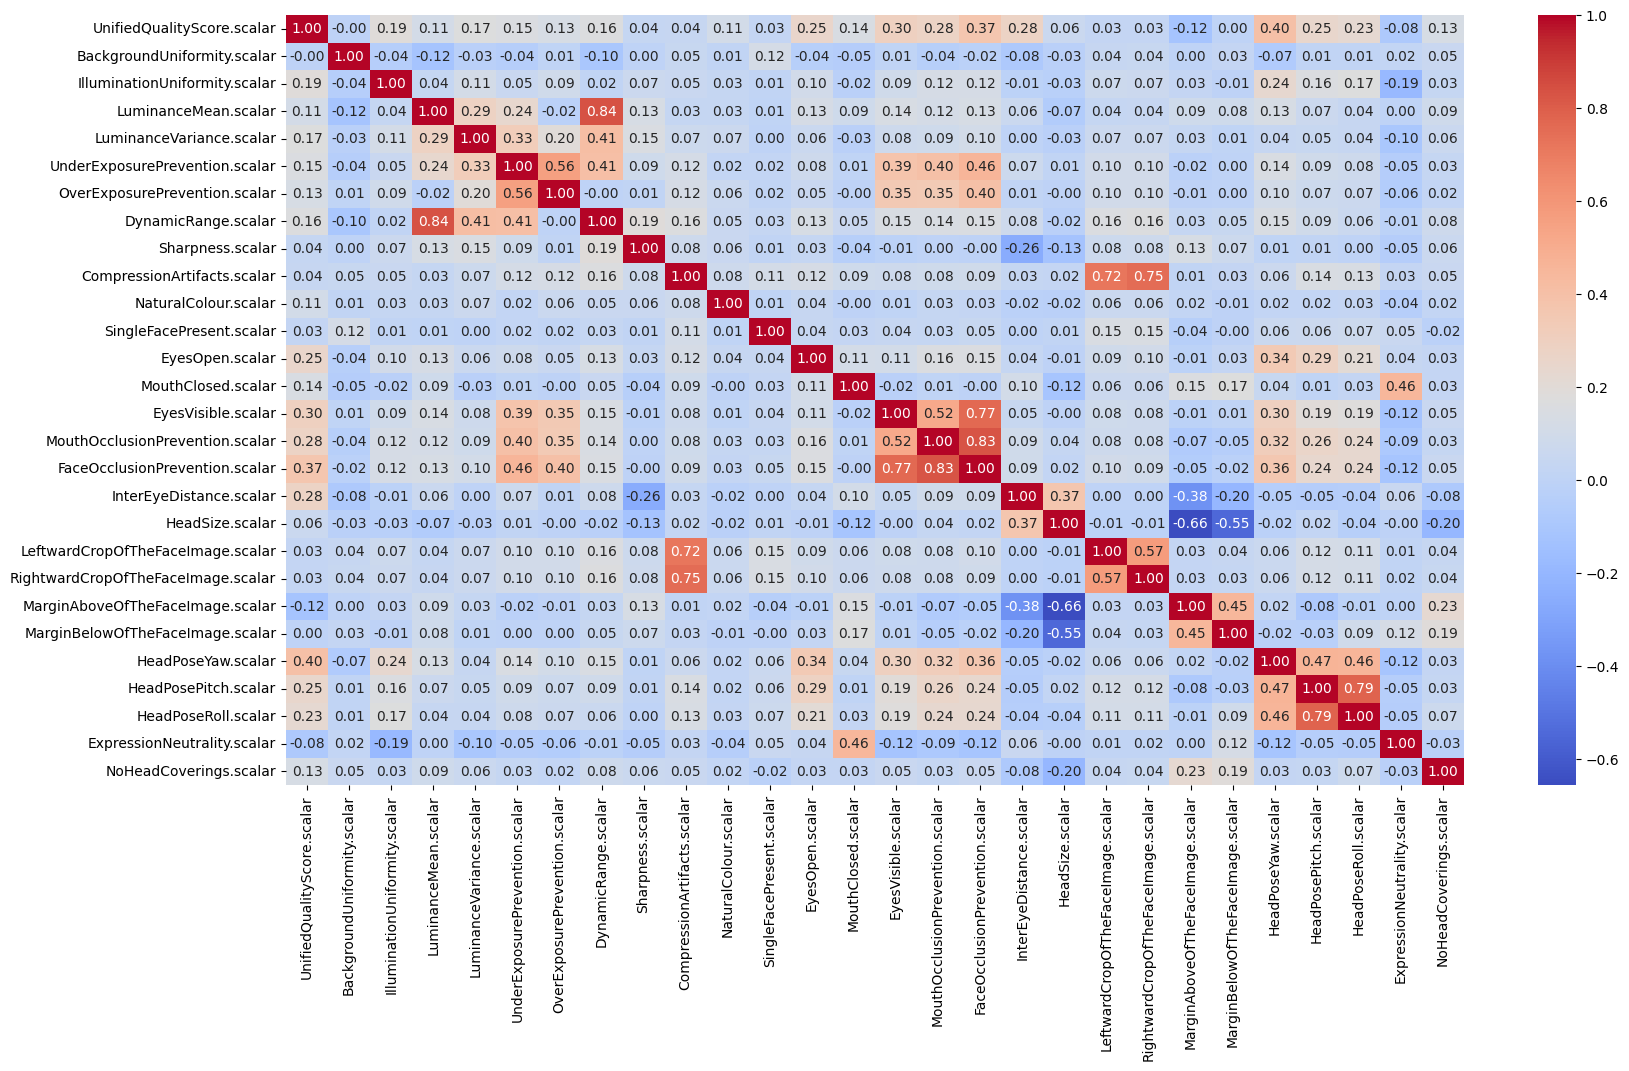

In [124]:
correlations = train_df.corr()
plt.figure(figsize=(19,10))
sns.heatmap(correlations, annot=True, cmap='coolwarm', fmt=".2f")

In [125]:
# FaceOcclusionPrevention or EyesVisible and MouthOcclusionPrevention?
# Remove ExpressionNeutrality or the ones it correlates with?
# train_df = train_df.drop(columns=['DynamicRange', 'HeadSize',
#                                   'LeftwardCropOfTheFaceImage', 'RightwardCropOfTheFaceImage', 
#                                   'MarginAboveOfTheFaceImage', 'MarginBelowOfTheFaceImage'])
# train_df = train_df.drop(columns=['DynamicRange.scalar', 'HeadSize.scalar',
#                                   'LeftwardCropOfTheFaceImage.scalar', 'RightwardCropOfTheFaceImage.scalar', 
#                                   'MarginAboveOfTheFaceImage.scalar', 'MarginBelowOfTheFaceImage.scalar'])

<Axes: >

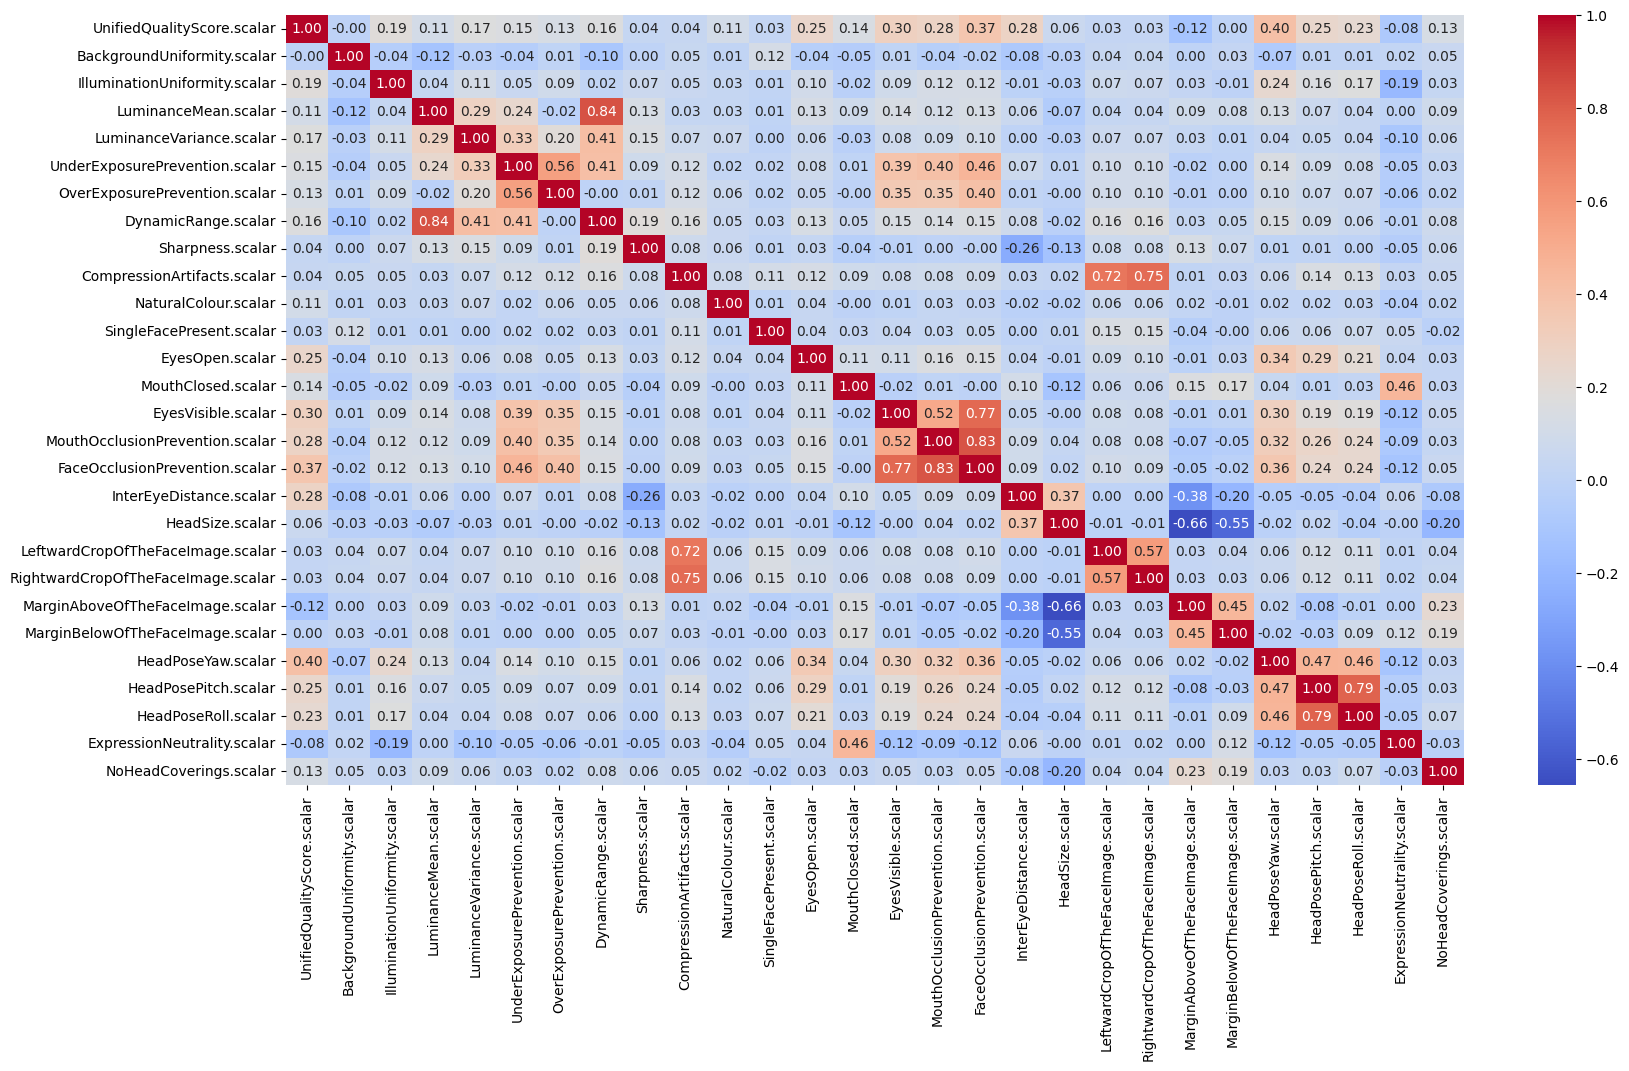

In [126]:
corr_after_drop = train_df.corr()
plt.figure(figsize=(19,10))
sns.heatmap(corr_after_drop, annot=True, cmap='coolwarm', fmt=".2f")

## UQS histogram

<Axes: xlabel='UnifiedQualityScore.scalar', ylabel='Count'>

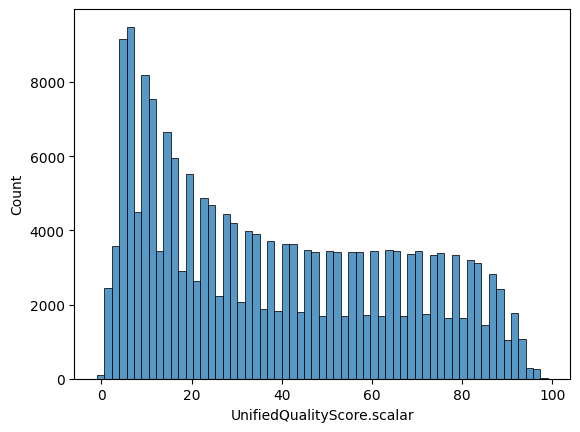

In [127]:
# sns.histplot(
#     train_df,
#     x=train_df['UnifiedQualityScore']
# )

sns.histplot(
    train_df,
    x=train_df['UnifiedQualityScore.scalar']
)

In [128]:
# Consider logarithmic on non-scalar scores, so UnifiedQualityScore for example 
# train_df['UnifiedQualityScore_Log'] = np.log1p(train_df['UnifiedQualityScore'])

In [129]:
column_names = train_df.select_dtypes(include=['int64', 'float64']).columns
# column_names = column_names.drop('UnifiedQualityScore')
column_names = column_names.drop('UnifiedQualityScore.scalar')

In [130]:
# Impute to fill missing values. Might not be necessary...
impute_and_scale_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

In [131]:
columns_transformed = ColumnTransformer(transformers=[
    ('num_p', impute_and_scale_pipeline, column_names)
    ],
    remainder='passthrough', 
    n_jobs=-1)

In [132]:
preprocess_pipeline = Pipeline(steps=[
    ('preprocessing', columns_transformed)
])

In [133]:
# X = train_df.drop('UnifiedQualityScore', axis=1)
# y = train_df['UnifiedQualityScore']
# X_raw = raw_df.drop('UnifiedQualityScore', axis=1)
# y_raw = raw_df['UnifiedQualityScore']

X = train_df.drop('UnifiedQualityScore.scalar', axis=1)
y = train_df['UnifiedQualityScore.scalar']
X_raw = raw_df.drop('UnifiedQualityScore.scalar', axis=1)
y_raw = raw_df['UnifiedQualityScore.scalar']
X_specific_dataset = specific_dataset_df.drop('UnifiedQualityScore.scalar', axis=1)
y_specific_dataset = specific_dataset_df['UnifiedQualityScore.scalar']

In [134]:
X_preprocessed = preprocess_pipeline.fit_transform(X)
X_raw_preprocessed = preprocess_pipeline.fit_transform(X_raw)
X_specific_dataset_preprocessed = preprocess_pipeline.fit_transform(X_specific_dataset)

X_train, X_test, y_train, y_test, filenames_train, filenames_test = train_test_split(X_preprocessed, y, filenames, test_size=0.2, random_state=36)

In [135]:
random_forest_regressor = RandomForestRegressor(random_state=36)

In [136]:
# there are more parameters that we can try to optimize
# Also, maybe consider using Optuna instead
grid_parameters = {
    'max_depth': [30],
    'n_estimators': [1500],
    'min_samples_split': [15]
}
# max_depth: 15, n_estimators: 500, min_samples_split: 10
#{'max_depth': 30, 'min_samples_split': 15, 'n_estimators': 1500} gives np.float64(2.171904031005836) and 4.803700372340917
# {'max_depth': 12, 'min_samples_split': 10, 'n_estimators': 300} gives np.float64(2.200307762445381) and 4.981448913268783
#{'max_depth': 30, 'min_samples_split': 15, 'n_estimators': 1500} gives np.float64(2.205441896749015) and 5.02581339484137 with a lot of columns removed
# Removing a lot of columns and FaceOcclusionPrevention as well makes it worse
#{'max_depth': 30, 'min_samples_split': 15, 'n_estimators': 1500} gives np.float64(2.1872035509314802) and 4.865764880207847 with some luminance stuff removed, headsize removed, margin averaged and crop averaged.
#{'max_depth': 30, 'min_samples_split': 15, 'n_estimators': 1500} gives 2.1734324686963307 and 4.820639260484793 with ['DynamicRange', 'HeadSize', 'LeftwardCropOfTheFaceImage', 'RightwardCropOfTheFaceImage', 'MarginAboveOfTheFaceImage', 'MarginBelowOfTheFaceImage']
#           removed and crop averaged and margin averaged.
#{'max_depth': 30, 'min_samples_split': 15, 'n_estimators': 1500} gives 17.560840972964996 and 310.4379027848181 with scalar version of ['DynamicRange', 'HeadSize', 'LeftwardCropOfTheFaceImage', 'RightwardCropOfTheFaceImage', 'MarginAboveOfTheFaceImage', 'MarginBelowOfTheFaceImage']
#           removed and crop averaged and margin averaged.
#{'max_depth': 30, 'min_samples_split': 15, 'n_estimators': 1500} gives 17.520939310617074 and 308.58041605776316 with everything kept (scalar)
#{'max_depth': 30, 'min_samples_split': 15, 'n_estimators': 1500} gives 17.32108712973725 and 298.34084529501126 using all native CQMs to predict scalar UQS. Takes a looong time to train though. 
 


In [137]:
# Create grid for RandomSearchCV
n_estimators = [int(i) for i in np.linspace(start = 200, stop = 2000, num = 10)]
max_depth = [int(i) for i in np.linspace(10, 100, num = 10)]
max_depth.append(None)
max_features = ["sqrt"]
min_samples_leaf = [1, 2, 4]
min_samples_split = [2, 5, 10, 20]
bootstrap = [True, False]

randomized_search_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'max_features': max_features,
               'min_samples_leaf': min_samples_leaf,
               'min_samples_split': min_samples_split,
               'bootstrap': bootstrap}

In [138]:
# random_forest_cross_val = GridSearchCV(random_forest_regressor, grid_parameters, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
random_forest_cross_val = RandomizedSearchCV(estimator = random_forest_regressor, 
                                             param_distributions = randomized_search_grid,
                                             n_iter = 100,
                                             cv = 3,
                                             verbose=3,
                                             random_state=36,
                                             n_jobs = -1)

In [ ]:
random_forest_cross_val.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


In [104]:
random_forest_cross_val.best_estimator_

RandomForestRegressor(bootstrap=False, max_depth=30, max_features='sqrt',
                      min_samples_split=20, n_estimators=1200, random_state=36)

In [105]:
random_forest_cross_val.best_params_

{'n_estimators': 1200,
 'min_samples_split': 20,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 30,
 'bootstrap': False}

In [69]:
model_filename = "rfr_UQS_scalar_to_scalar_RandomizedSearchCV_VGGFace-200k.pkl"

In [ ]:

joblib.dump(random_forest_cross_val, model_filename)

['rfr_UQS_scalar_to_scalar_RandomizedSearchCV_VGGFace-200k.pkl']

In [71]:
load_saved_model_test = joblib.load(model_filename)

In [72]:
y_pred_from_saved_model = load_saved_model_test.predict(X_test)

In [73]:
X_test

array([[-0.3576972593433278, 0.7244242689540076, -0.7203150140855175,
        ..., -0.15497591656084775, 0.3362852796821638, '100'],
       [-1.8665225603606301, -2.116923330674506, -0.10153117404698477,
        ..., 0.2999586621185931, 0.3362852796821638, '100'],
       [0.9834807860053855, -0.6436319827189804, -1.892747553105895, ...,
        0.6499083380258553, 0.3362852796821638, '100'],
       ...,
       [0.10333269374529237, -0.9067197234253241, -1.892747553105895,
        ..., -0.01499604619794287, -1.0328780510749715, '93'],
       [-0.2738736315090332, -0.43316179015390527, 1.0057662239167051,
        ..., 1.2448227870682012, 0.3362852796821638, '71'],
       [0.8158335303367963, 0.9875120096603515, -0.5900447319721421, ...,
        0.2649636945278669, 0.3362852796821638, '100']], dtype=object)

In [74]:
X_specific_dataset_preprocessed

array([[-1.7853327950032887, -0.24705361916012716, 0.7521923799042984,
        ..., -0.9414243138893867, 0.32912989143215704, '100'],
       [-2.1193285250050415, 0.6118332398588896, -2.16437161513549, ...,
        -1.0107173574959358, 0.32912989143215704, '100'],
       [-0.9920929362491254, 1.0949570980570864, 0.9895871236866068, ...,
        -0.49101953044681795, 0.32912989143215704, '100'],
       ...,
       [-0.4910993412464961, -0.7838579060470126, 1.023500658512651, ...,
        -0.0752612688075237, 0.32912989143215704, '95'],
       [0.38563945000810534, -3.199477197037997, -2.130458080309446, ...,
        0.8601948198808883, 0.32912989143215704, '0'],
       [1.1371298425120493, -0.5691361912922585, -1.5200144534406532,
        ..., -0.005968225200974663, 0.32912989143215704, '98']],
      dtype=object)

In [75]:
y_specific_dataset_pred_from_saved_model = load_saved_model_test.predict(X_specific_dataset_preprocessed)

In [76]:
y_pred_from_saved_model

array([72.19661467, 43.88234495, 64.51567552, ...,  9.13390309,
        8.66084137, 74.037875  ])

In [77]:
y_specific_dataset_pred_from_saved_model

array([63.73198753, 49.29454684, 33.86277079, ..., 10.79991668,
        6.03037571, 14.84606856])

In [78]:
specific_dataset_predictions_saved_model_df = pd.DataFrame(y_specific_dataset_pred_from_saved_model)
filename_and_predicted_UQS_specific_dataset = pd.concat([filenames_specific_dataset, specific_dataset_predictions_saved_model_df], axis=1)
filename_and_predicted_UQS_specific_dataset.to_csv('Predicted-UQS_Specific_Dataset.csv', index=False, sep=';')

In [ ]:
# test_check = specific_dataset_df[45-252_03]
# test_check = specific_dataset_df[~specific_dataset_df['Filename'].apply(lambda x: '45-252_03' in x)]

In [81]:
np.sqrt(-1 * random_forest_cross_val.best_score_)

C:\Users\admin\AppData\Local\Temp\ipykernel_24900\3589293594.py:1: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(-1 * random_forest_cross_val.best_score_)


np.float64(nan)

In [82]:
random_forest_cross_val.best_params_

{'n_estimators': 1200,
 'min_samples_split': 20,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 30,
 'bootstrap': False}

In [83]:
y_pred_random_forest = random_forest_cross_val.predict(X_test)

In [84]:
y_pred_random_forest

array([72.19661467, 43.88234495, 64.51567552, ...,  9.13390309,
        8.66084137, 74.037875  ])

In [85]:
y_test

155246    86
69936     25
3284      81
131547    91
12639     72
          ..
133722    84
141235    20
159196     6
59781      6
16219     74
Name: UnifiedQualityScore.scalar, Length: 39504, dtype: int64

In [86]:
mean_squared_error(y_test, y_pred_random_forest)

258.4453493326076

In [87]:
mean_absolute_error(y_test, y_pred_random_forest)

12.550342514579025

In [88]:
mean_absolute_percentage_error(y_test, y_pred_random_forest)

2577425778123.5293

In [89]:
predictions_for_raw_dataset_random_forest = random_forest_cross_val.predict(X_raw_preprocessed)

In [90]:
predictions_raw_df = pd.DataFrame(predictions_for_raw_dataset_random_forest)
filename_raw_df = raw_copy_df["Filename"]
filename_and_predicted_UQS_Raw = pd.concat([filename_raw_df, predictions_raw_df], axis=1)
filename_and_predicted_UQS_Raw.to_csv('Predicted-UQS_LFW-RandomizedSearchCV.csv', index=False, sep=';')

In [91]:
predictions_test_set_df = pd.DataFrame(y_pred_random_forest)
filename_and_predicted_UQS_Raw = pd.concat([filenames_test, predictions_test_set_df], axis=1)
filename_and_predicted_UQS_Raw.to_csv('Predicted-UQS_TestSet-RandomizedSearchCV.csv', index=False, sep=';')

In [92]:
# random_forest_specific = RandomForestRegressor(n_estimators=1000, max_depth= 20, min_samples_split=20, random_state=13)

In [93]:
# model_test = random_forest_specific.fit(X_train, y_train)

In [94]:
without_uqs = train_df.drop(columns=['UnifiedQualityScore.scalar'])
# without_uqs = train_df.drop(columns=['UnifiedQualityScore'])

In [95]:
# y_pred_single = model_test.predict(X_test)

In [ ]:
# y_pred_single

In [ ]:
# y_test

In [ ]:
# mean_squared_error(y_test, y_pred_single)

In [ ]:
# mean_absolute_error(y_test, y_pred_single)

In [ ]:
# mean_absolute_percentage_error(y_test, y_pred_single)

In [ ]:
# TODO: Add link to where I found this.
def plot_feature_importance(model, names, threshold = None):
    feature_importance_df = pd.DataFrame.from_dict({'feature_importance': model.feature_importances_,
                                                    'feature': names})\
            .set_index('feature').sort_values('feature_importance', ascending = False)

    if threshold is not None:
        feature_importance_df = feature_importance_df[feature_importance_df.feature_importance > threshold]

    fig = px.bar(
        feature_importance_df,
        text_auto = '.2f',
        labels = {'value': 'feature importance'},
        title = 'Feature importances'
    )

    fig.update_layout(showlegend = False)
    fig.show()

# plot_feature_importance(model_test, without_uqs.columns)

In [ ]:
plot_feature_importance(random_forest_cross_val.best_estimator_, without_uqs.columns)

In [103]:
permutation_importance = permutation_importance(random_forest_cross_val.best_estimator_, X_test, y_test)

KeyboardInterrupt: 

In [1421]:
permutation_importance

{'importances_mean': array([8.32219067e-03, 2.14304758e-03, 2.65494922e-03, 2.61977715e-02,
        2.46963599e-03, 7.40459977e-03, 1.07068486e-02, 8.87054959e-02,
        8.72153022e-03, 1.57395046e-03, 2.59313196e-04, 6.26348154e-02,
        4.91719497e-02, 1.17294181e-02, 2.84019213e-03, 2.87823584e-01,
        3.15388029e-02, 5.01573070e-03, 1.30876530e-02, 5.89828972e-03,
        5.15594597e-03, 5.19327699e-02, 2.75917757e-02, 2.87326710e-02,
        5.90915903e-03, 1.34304772e-02, 5.84076931e-02]),
 'importances_std': array([0.000722  , 0.00040502, 0.00053008, 0.00217222, 0.00045304,
        0.00095735, 0.00046779, 0.00373854, 0.00053011, 0.00033335,
        0.00011077, 0.0032328 , 0.0010678 , 0.00090314, 0.0006368 ,
        0.0078177 , 0.00199336, 0.00048395, 0.00098681, 0.00042629,
        0.00033526, 0.00146953, 0.00070057, 0.00235752, 0.00085991,
        0.00073942, 0.00142619]),
 'importances': array([[7.97703821e-03, 7.90314745e-03, 9.07239234e-03, 7.39410020e-03,
         

In [1419]:
rand_forest_best_estimator = random_forest_cross_val.best_estimator_
importances = np.zeros((len(rand_forest_best_estimator.estimators_), rand_forest_best_estimator.n_features_in_))
for i,tree in enumerate(rand_forest_best_estimator.estimators_):
    importances[i] = tree.tree_.compute_feature_importances(normalize=False)
np.mean(importances, axis=0)

array([ 13.92897137,  10.72554948,   7.98598301,  16.12553778,
         9.71886882,   6.2733968 ,  10.32076502,  36.81052334,
        13.08066969,   4.26165896,   1.4293702 ,  48.58339614,
        26.92727165,   5.61523715,   2.62882817, 106.63023128,
        16.8607387 ,   6.24034098,  11.12696753,   9.11526271,
         7.44679608,  16.11783192,  22.60447373,  23.18052345,
        11.42836278,  15.26027707,  22.82569634])

In [1353]:
train_df.mean()

BackgroundUniformity            104.073900
IlluminationUniformity            0.453054
LuminanceMean                     0.263470
LuminanceVariance                 0.022051
UnderExposurePrevention           0.185613
OverExposurePrevention            0.001017
DynamicRange                      6.828051
Sharpness                        18.249086
CompressionArtifacts              0.969519
NaturalColour                     2.066408
SingleFacePresent                 0.022476
EyesOpen                          0.075268
MouthClosed                       0.077109
EyesVisible                       0.061145
MouthOcclusionPrevention          0.013321
FaceOcclusionPrevention           0.054590
InterEyeDistance                208.955702
HeadSize                          0.406595
LeftwardCropOfTheFaceImage        2.826080
RightwardCropOfTheFaceImage       2.823054
MarginAboveOfTheFaceImage         1.200000
MarginBelowOfTheFaceImage         1.339362
HeadPoseYaw                      -0.273713
HeadPosePit

In [1354]:
# TODO: What is this?? Doesn't seem to make sense...
x_test_dataframe = pd.DataFrame(X_test)
x_test_dataframe["prediction_mean"] = 48.490778
predictions_mean = x_test_dataframe["prediction_mean"]
x_test_dataframe.drop(columns=["prediction_mean"])
predictions_mean.head()



0    48.490778
1    48.490778
2    48.490778
3    48.490778
4    48.490778
Name: prediction_mean, dtype: float64

In [1355]:
mean_squared_error(y_test, predictions_mean)

571.538881720651

In [1356]:
mean_absolute_error(y_test, predictions_mean)

20.62114366463467

In [1357]:
mean_absolute_percentage_error(y_test, predictions_mean)

0.7995669833924303

In [1358]:
root_mean_squared_error(y_test, predictions_mean)

23.906879380643787

## Scatter stuff

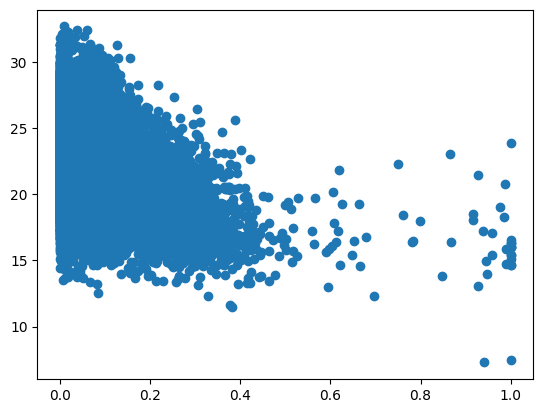

In [ ]:
plt.scatter(x='FaceOcclusionPrevention', y='UnifiedQualityScore', data=train_df)

In [ ]:
to_remove = train_df.query('FaceOcclusionPrevention > 0.7')

In [ ]:
train_df = train_df[train_df.index.isin(to_remove.index) == False]


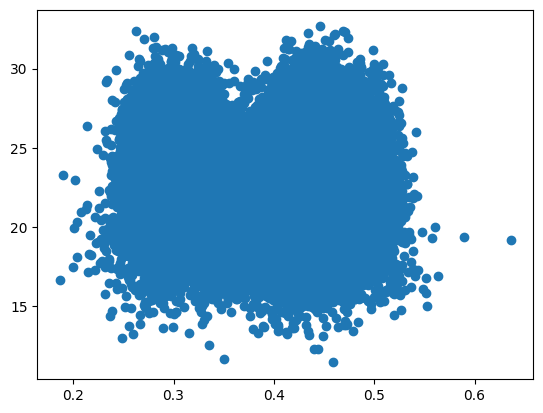

In [ ]:
plt.scatter(x='HeadSize', y='UnifiedQualityScore', data=train_df)
to_remove = train_df.query('HeadSize > 0.575')
to_remove
train_df = train_df[train_df.index.isin(to_remove.index) == False]


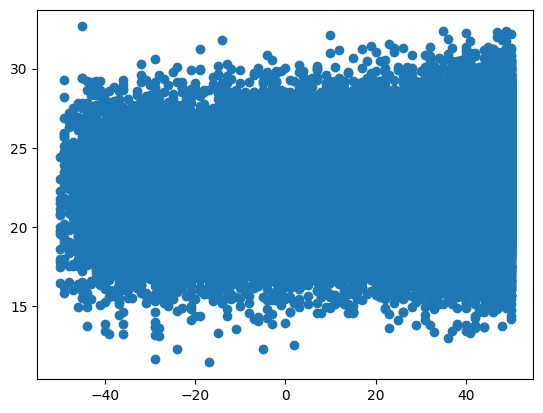

In [ ]:
plt.scatter(x='Sharpness', y='UnifiedQualityScore', data=train_df)
to_remove = train_df.query('Sharpness < 0 and UnifiedQualityScore > 31')
train_df = train_df[train_df.index.isin(to_remove.index) == False]
to_remove = train_df.query('Sharpness < 0 and UnifiedQualityScore < 13')
train_df = train_df[train_df.index.isin(to_remove.index) == False]


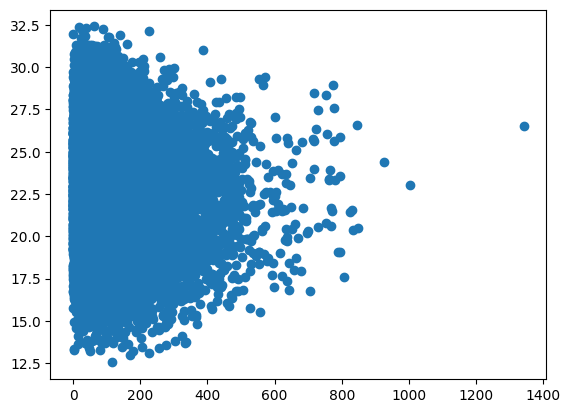

In [ ]:
plt.scatter(x='BackgroundUniformity', y='UnifiedQualityScore', data=train_df)
to_remove = train_df.query('BackgroundUniformity > 900')
train_df = train_df[train_df.index.isin(to_remove.index) == False]

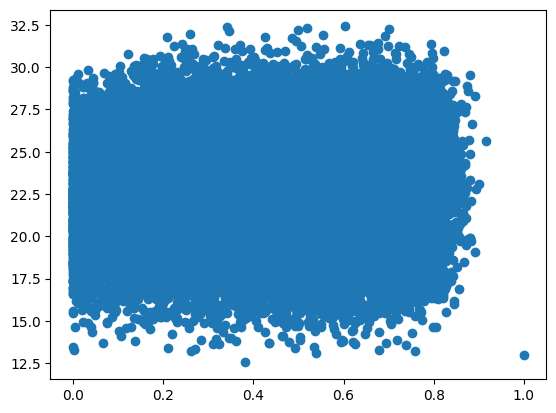

In [ ]:
plt.scatter(x='IlluminationUniformity', y='UnifiedQualityScore', data=train_df)
to_remove = train_df.query('UnifiedQualityScore < 13')
train_df = train_df[train_df.index.isin(to_remove.index) == False]

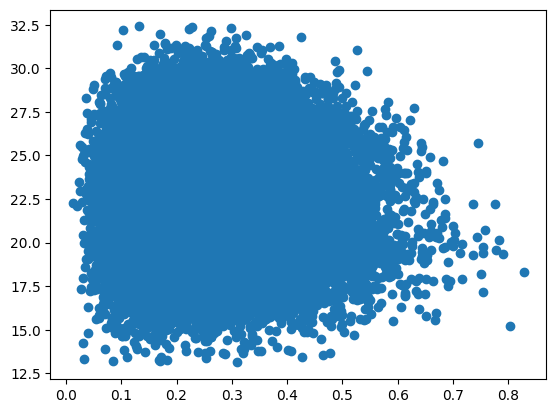

In [ ]:
plt.scatter(x='LuminanceMean', y='UnifiedQualityScore', data=train_df)
to_remove = train_df.query('LuminanceMean > 0.8')
train_df = train_df[train_df.index.isin(to_remove.index) == False]

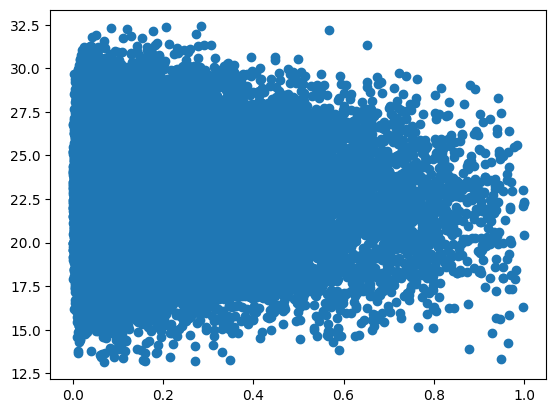

In [ ]:
plt.scatter(x='UnderExposurePrevention', y='UnifiedQualityScore', data=train_df)
to_remove = train_df.query('UnderExposurePrevention > 0.85 and UnifiedQualityScore < 16')
train_df = train_df[train_df.index.isin(to_remove.index) == False]
to_remove = train_df.query('UnderExposurePrevention > 0.4 and UnifiedQualityScore > 31')
train_df = train_df[train_df.index.isin(to_remove.index) == False]

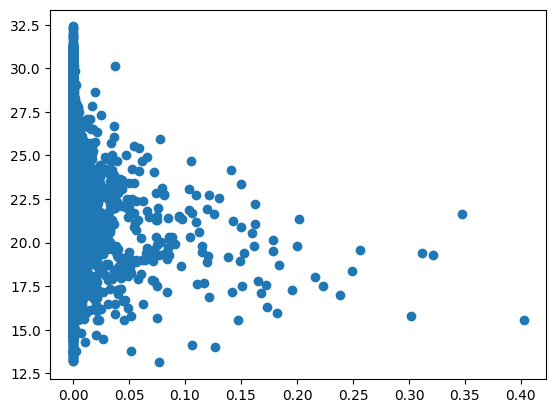

In [ ]:
plt.scatter(x='OverExposurePrevention', y='UnifiedQualityScore', data=train_df)
to_remove = train_df.query('OverExposurePrevention > 0.275')
train_df = train_df[train_df.index.isin(to_remove.index) == False]

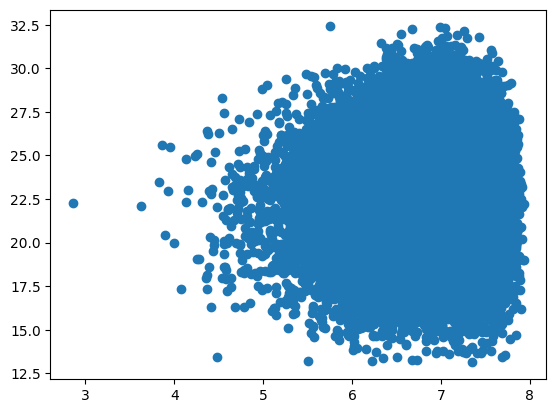

In [ ]:
plt.scatter(x='DynamicRange', y='UnifiedQualityScore', data=train_df)
to_remove = train_df.query('DynamicRange < 3.5')
train_df = train_df[train_df.index.isin(to_remove.index) == False]
to_remove = train_df.query('DynamicRange < 5.75 and UnifiedQualityScore < 13.5')
train_df = train_df[train_df.index.isin(to_remove.index) == False]
to_remove = train_df.query('DynamicRange < 6 and UnifiedQualityScore > 32')
train_df = train_df[train_df.index.isin(to_remove.index) == False]

In [ ]:
#plt.scatter(x='CompressionArtifacts', y='UnifiedQualityScore', data=train_df)
#to_remove = train_df.query('CompressionArtifacts < 0.75')
#train_df = train_df[train_df.index.isin(to_remove.index) == False]

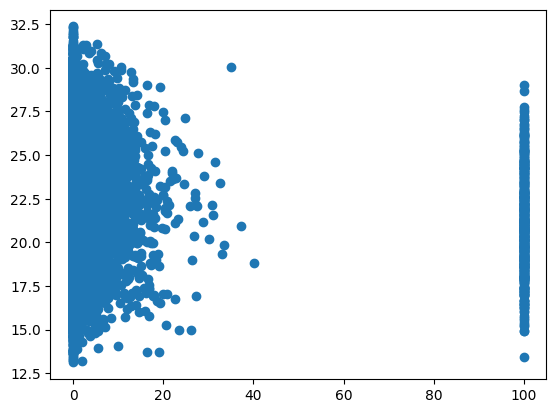

In [ ]:
plt.scatter(x='NaturalColour', y='UnifiedQualityScore', data=train_df)


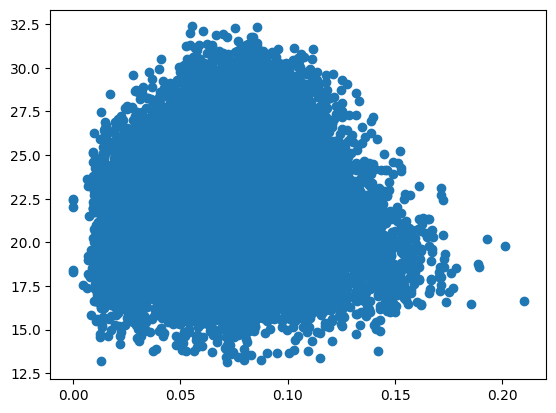

In [ ]:
plt.scatter(x='EyesOpen', y='UnifiedQualityScore', data=train_df)
to_remove = train_df.query('EyesOpen > 0.17')
train_df = train_df[train_df.index.isin(to_remove.index) == False]

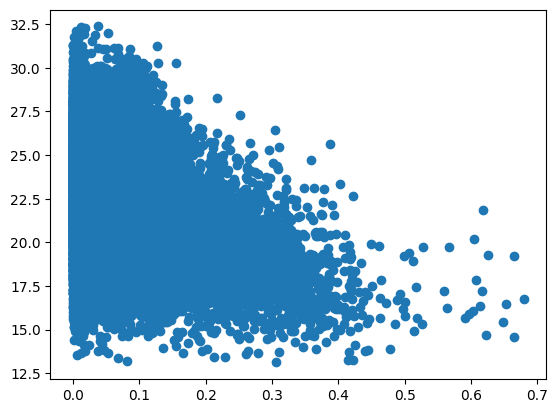

In [ ]:
plt.scatter(x='FaceOcclusionPrevention', y='UnifiedQualityScore', data=train_df)
to_remove = train_df.query('FaceOcclusionPrevention > 0.5')
train_df = train_df[train_df.index.isin(to_remove.index) == False]

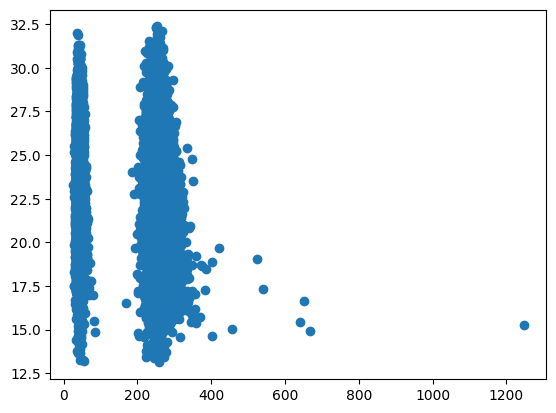

In [ ]:
plt.scatter(x='InterEyeDistance', y='UnifiedQualityScore', data=train_df)
to_remove = train_df.query('InterEyeDistance > 400')
train_df = train_df[train_df.index.isin(to_remove.index) == False]

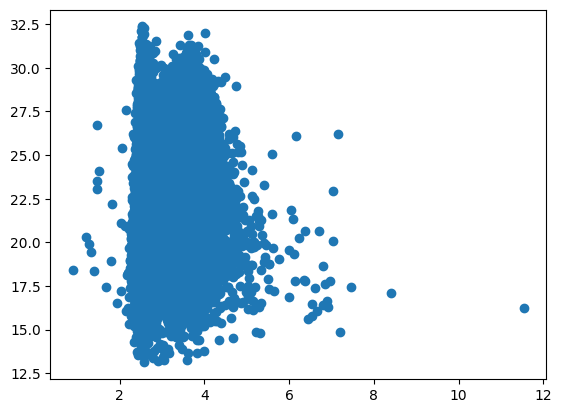

In [ ]:
plt.scatter(x='LeftwardCropOfTheFaceImage', y='UnifiedQualityScore', data=train_df)
to_remove = train_df.query('LeftwardCropOfTheFaceImage > 5.5 or LeftwardCropOfTheFaceImage < 2')
train_df = train_df[train_df.index.isin(to_remove.index) == False]

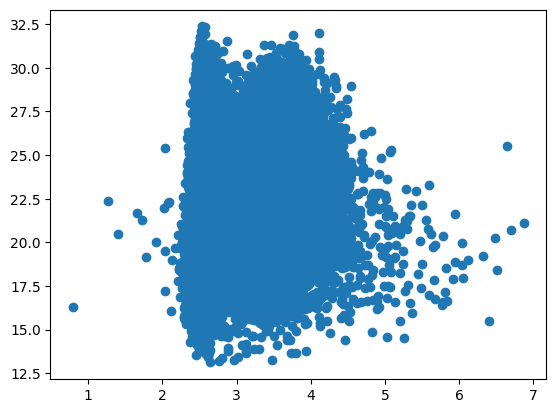

In [ ]:
plt.scatter(x='RightwardCropOfTheFaceImage', y='UnifiedQualityScore', data=train_df)
to_remove = train_df.query('RightwardCropOfTheFaceImage > 5 or RightwardCropOfTheFaceImage < 2')
train_df = train_df[train_df.index.isin(to_remove.index) == False]

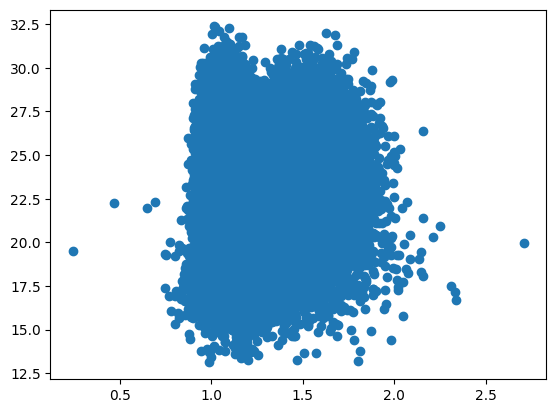

In [ ]:
plt.scatter(x='MarginAboveOfTheFaceImage', y='UnifiedQualityScore', data=train_df)
to_remove = train_df.query('MarginAboveOfTheFaceImage > 2.0 or MarginAboveOfTheFaceImage < 0.75')
train_df = train_df[train_df.index.isin(to_remove.index) == False]

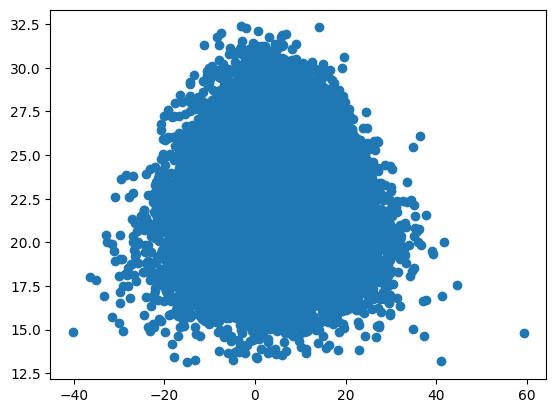

In [ ]:
plt.scatter(x='HeadPosePitch', y='UnifiedQualityScore', data=train_df)
to_remove = train_df.query('HeadPosePitch > 38 or HeadPosePitch < -32')
train_df = train_df[train_df.index.isin(to_remove.index) == False]

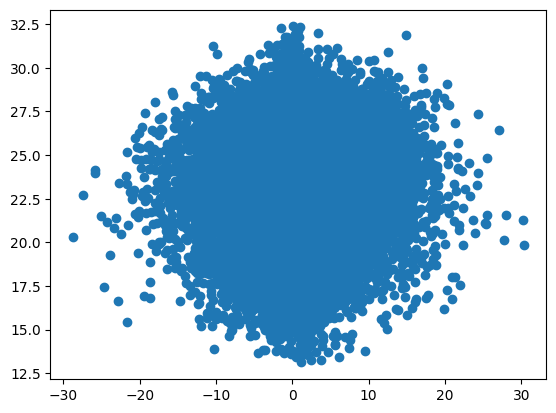

In [ ]:
plt.scatter(x='HeadPoseRoll', y='UnifiedQualityScore', data=train_df)
to_remove = train_df.query('HeadPoseRoll > 25 or HeadPoseRoll < -23')
train_df = train_df[train_df.index.isin(to_remove.index) == False]

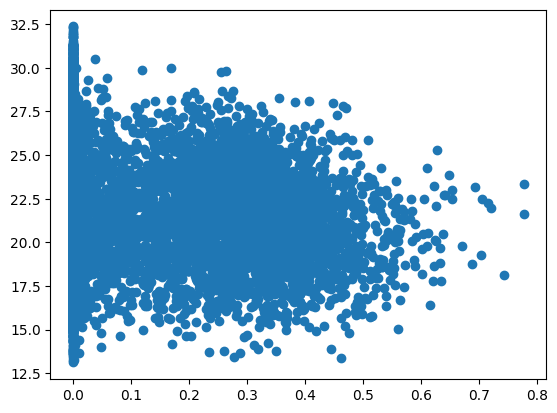

In [ ]:
plt.scatter(x='NoHeadCoverings', y='UnifiedQualityScore', data=train_df)
to_remove = train_df.query('NoHeadCoverings > 0.0')


In [ ]:
to_remove

,Filename,UnifiedQualityScore,BackgroundUniformity,IlluminationUniformity,LuminanceMean,LuminanceVariance,UnderExposurePrevention,OverExposurePrevention,DynamicRange,Sharpness,...,LeftwardCropOfTheFaceImage.scalar,RightwardCropOfTheFaceImage.scalar,MarginAboveOfTheFaceImage.scalar,MarginBelowOfTheFaceImage.scalar,HeadPoseYaw.scalar,HeadPosePitch.scalar,HeadPoseRoll.scalar,ExpressionNeutrality.scalar,NoHeadCoverings.scalar,Unnamed: 57
2,C://Users//admin//Downloads//lfw//flat_lfw/Aar...,17.987562,64.520862,0.459137,0.243947,0.013221,0.110664,0.000000,6.794354,-34,...,100,100,93,80,96,100,87,98,2,NaN
11,C://Users//admin//Downloads//lfw//flat_lfw/Abb...,21.176453,34.409306,0.347107,0.188585,0.008847,0.054985,0.000292,6.458166,49,...,100,100,86,71,93,97,100,92,100,NaN
13,C://Users//admin//Downloads//lfw//flat_lfw/Abd...,19.427111,187.851509,0.506939,0.154711,0.010546,0.320706,0.000000,6.343090,35,...,100,100,90,73,87,100,100,42,5,NaN
59,C://Users//admin//Downloads//lfw//flat_lfw/Abi...,20.982929,95.567391,0.550964,0.118109,0.009254,0.473144,0.000000,6.237744,19,...,100,100,92,66,99,100,100,31,80,NaN
60,C://Users//admin//Downloads//lfw//flat_lfw/Abi...,19.047457,2.122254,0.507804,0.337729,0.062064,0.205436,0.000000,7.618697,-10,...,100,100,40,18,86,99,90,68,14,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33203,C://Users//admin//Desktop//Flickr-10000/19970.png,23.995432,44.641841,0.687500,0.227527,0.021921,0.164453,0.000018,7.069655,49,...,100,100,6,0,100,100,100,24,47,NaN
33214,C://Users//admin//Desktop//Flickr-10000/19981.png,22.450264,228.788538,0.035918,0.184828,0.038557,0.475200,0.000203,6.859678,47,...,100,100,32,3,99,75,100,74,80,NaN
33217,C://Users//admin//Desktop//Flickr-10000/19984.png,19.829638,166.259163,0.355469,0.162764,0.008873,0.216803,0.000000,6.402817,-29,...,100,100,4,0,92,99,100,31,4,NaN
33218,C://Users//admin//Desktop//Flickr-10000/19985.png,21.662836,142.721059,0.194637,0.323294,0.072344,0.218198,0.000000,7.401826,-34,...,100,100,2,0,100,80,100,11,4,NaN


In [1412]:
# train_df = pd.read_csv(sep=';', filepath_or_buffer='C:\\Users\\admin\\source\\repos\\OFIQ-Project\\install_x86_64\\Release\\bin\\LFW_scores.csv')
# train_df = pd.read_csv(sep=';', filepath_or_buffer='C:\\Users\\admin\\source\\repos\\OFIQ-Project\\install_x86_64\\Release\\bin\\Flickr-0to9999.csv')
train_df = pd.read_csv(sep=';', filepath_or_buffer='C:\\Users\\admin\\source\\repos\\OFIQ-Project\\install_x86_64\\Release\\bin\\combined_files.csv')
# train_df = pd.read_csv(sep=';', filepath_or_buffer='C:\\Users\\admin\\source\\repos\\OFIQ-Project\\install_x86_64\\Release\\bin\\Flickr-only.csv')


In [1413]:
print(len(train_df.index))

train_df = train_df[(train_df['UnifiedQualityScore.scalar'] < 100 ) & (train_df['BackgroundUniformity.scalar'] < 100) & (train_df['IlluminationUniformity.scalar'] < 100) & (train_df['LuminanceMean.scalar'] < 100) & (train_df['LuminanceVariance.scalar'] < 100)]
print(len(train_df.index))

# train_df = train_df[(train_df['UnderExposurePrevention.scalar'] < 100 )]
# print(len(train_df.index))

# train_df = train_df[(train_df['OverExposurePrevention.scalar'] < 100 )]
# print(len(train_df.index))

train_df = train_df[(train_df['DynamicRange.scalar'] < 100 )]
print(len(train_df.index))

train_df = train_df[(train_df['Sharpness.scalar'] < 100 )]
print(len(train_df.index))

# train_df = train_df[(train_df['CompressionArtifacts.scalar'] < 100 )]
# print(len(train_df.index))

# train_df = train_df[(train_df['NaturalColour.scalar'] < 100 )]
# print(len(train_df.index))

# train_df = train_df[(train_df['UnderExposurePrevention.scalar'] < 100 ) & (train_df['OverExposurePrevention.scalar'] < 100 ) & (train_df['DynamicRange.scalar'] < 100 ) & (train_df['Sharpness.scalar'] < 100 ) & (train_df['CompressionArtifacts.scalar'] < 100 ) & (train_df['NaturalColour.scalar'] < 100 )]
# print(len(train_df.index))




# train_df = train_df[(train_df['SingleFacePresent.scalar'] < 100 )]
# print(len(train_df.index))

train_df = train_df[(train_df['EyesOpen.scalar'] < 100 )]
print(len(train_df.index))

train_df = train_df[(train_df['MouthClosed.scalar'] < 100 )]
print(len(train_df.index))

train_df = train_df[(train_df['EyesVisible.scalar'] < 100 )]
print(len(train_df.index))

train_df = train_df[(train_df['MouthOcclusionPrevention.scalar'] < 100 )]
print(len(train_df.index))


train_df = train_df[(train_df['FaceOcclusionPrevention.scalar'] < 100)]
print(len(train_df.index))


# train_df = train_df[(train_df['SingleFacePresent.scalar'] < 100 ) & (train_df['EyesOpen.scalar'] < 100 ) & (train_df['MouthClosed.scalar'] < 100 ) & (train_df['EyesVisible.scalar'] < 100 ) & (train_df['MouthOcclusionPrevention.scalar'] < 100 ) & (train_df['FaceOcclusionPrevention.scalar'] < 100)]
# print(len(train_df.index))






train_df = train_df[(train_df['InterEyeDistance.scalar'] < 100 ) & (train_df['HeadSize.scalar'] < 100 ) & (train_df['LeftwardCropOfTheFaceImage.scalar'] < 100 ) & (train_df['RightwardCropOfTheFaceImage.scalar'] < 100 ) & (train_df['MarginAboveOfTheFaceImage.scalar'] < 100)]
print(len(train_df.index))




train_df = train_df[(train_df['MarginBelowOfTheFaceImage.scalar'] < 100 )]
print(len(train_df.index))


train_df = train_df[(train_df['HeadPoseYaw.scalar'] < 100 )]
print(len(train_df.index))


train_df = train_df[(train_df['HeadPosePitch.scalar'] < 100 )]
print(len(train_df.index))


train_df = train_df[(train_df['HeadPoseRoll.scalar'] < 100 )]
print(len(train_df.index))



train_df = train_df[(train_df['ExpressionNeutrality.scalar'] < 100 )]
print(len(train_df.index))

train_df = train_df[(train_df['NoHeadCoverings.scalar'] < 100)]
print(len(train_df.index))

# train_df = train_df[(train_df['MarginBelowOfTheFaceImage.scalar'] < 100 ) & (train_df['HeadPoseYaw.scalar'] < 100 ) & (train_df['HeadPosePitch.scalar'] < 100 ) & (train_df['HeadPoseRoll.scalar'] < 100 ) & (train_df['ExpressionNeutrality.scalar'] < 100 ) & (train_df['NoHeadCoverings.scalar'] < 100)]
# print(len(train_df.index))
       

# More than half of all photos have MarginBelowOfTheFaceImage <= 0...

58233
49731
49731
37470
16051
16051
4716
320
320
0
0
0
0
0
0
0
